In [1]:
import torch
from torch import nn
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import csv
import math
import random

In [2]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)       # Python random module.
    np.random.seed(seed_value)    # Numpy module.
    torch.manual_seed(seed_value) # PyTorch.

    # If you are using CUDA, you should also set:
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
N_FOLDS = 5

train_folds = [
    ['0030', '4008', '0025', '2008', '0018', '4003', '2006', '5018', '5019', '5034', '1008', '5010', '5006', '5004', '5003', '5002'],
    ['0030', '1006', '4008', '0029', '0025', '0018', '4003', '5018', '2013', '5031', '5019', '5034', '5010', '5006', '5004', '5003'],
    ['0030', '1006', '0029', '0025', '2008', '0018', '2006', '5018', '2013', '5031', '5019', '1008', '5006', '5004', '5003', '5002'],
    ['0030', '1006', '4008', '0029', '2008', '0018', '4003', '2006', '2013', '5031', '5019', '5034', '1008', '5010', '5004', '5002'],
    ['1006', '4008', '0029', '0025', '2008', '4003', '2006', '5018', '2013', '5031', '5034', '1008', '5010', '5006', '5003', '5002']
]

test_folds = [
    ['1006', '0029', '2013', '5031'],
    ['2008', '2006', '1008', '5002'],
    ['4008', '4003', '5034', '5010'],
    ['0025', '5018', '5006', '5003'],
    ['0030', '0018', '5019', '5004']
]

In [7]:
indoor_focused_videos = set()
outdoor_exploratory_videos = set()

data_types = {
    'Name': str,
    'indoor': bool,
    'type': str,
    'focus': bool
}

video_types = pd.read_csv('../../datasets/dsav360/video_types.csv', dtype=data_types)

for vid in train_folds[0] + test_folds[0]:
    row = video_types[video_types['Name'] == vid]
    if row['indoor'].iloc[0] and row['focus'].iloc[0]:
        indoor_focused_videos.add(vid)
    else:
        outdoor_exploratory_videos.add(vid)

print(indoor_focused_videos)
print(outdoor_exploratory_videos)

{'4003', '2008', '2006', '0029', '5018', '0030', '0025', '0018', '4008', '1006'}
{'5002', '5019', '5034', '5031', '5006', '2013', '1008', '5010', '5004', '5003'}


In [8]:
class LSTMHeadPosModel(nn.Module):
    def __init__(self, input_features=146, hidden_size=128, output_features=2, sequence_length=15):
        super(LSTMHeadPosModel, self).__init__()
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        
        # Define the first LSTM layer
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_size, batch_first=True)
        
        # Define the second LSTM layer
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        
        # Define the output layer
        self.dense = nn.Linear(hidden_size, output_features)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        
        # First LSTM layer
        x, (hn, cn) = self.lstm1(x, (h0, c0))
        
        # Second LSTM layer
        x, (hn, cn) = self.lstm2(x, (hn, cn))
        
        # Get the output from the last time step
        x = x[:, -1, :]  # Shape: (batch_size, hidden_size)
        
        # Pass the last time step's output to the dense layer to get final prediction
        x = self.dense(x)  # Shape: (batch_size, output_features)
        
        return x

In [9]:
def load_saliency_maps(directory, skip_size=1):
    saliency_maps = []
    files = sorted([file for file in os.listdir(directory) if file.endswith('.png')])[::skip_size]

    for file in files:
        file_path = os.path.join(directory, file)
        img = Image.open(file_path)
        img = img.resize((16, 9))
        saliency_map = np.array(img, dtype=np.float32) / 255.0
        saliency_maps.append(saliency_map.flatten()) 

    return np.array(saliency_maps)

def load_saliency_maps_for_all_videos(directory, skip_size=1, videos=None):
    saliency_dict = {}

    for video in os.listdir(directory):
        if videos and video not in videos:
            continue
        path = os.path.join(directory, video)
        saliency_dict[video] = load_saliency_maps(path, skip_size)

    return saliency_dict

In [10]:
gt_sal_map_dir = '../../datasets/dsav360/saliency_maps'
gt_train_sal_maps = load_saliency_maps_for_all_videos(gt_sal_map_dir, 15, train_folds[0])

In [11]:
for k, v in sorted(gt_train_sal_maps.items()):
    print(f'video: {k}, len: {len(v)}')

video: 0018, len: 120
video: 0025, len: 120
video: 0030, len: 120
video: 1008, len: 120
video: 2006, len: 120
video: 2008, len: 120
video: 4003, len: 120
video: 4008, len: 120
video: 5002, len: 120
video: 5003, len: 120
video: 5004, len: 120
video: 5006, len: 120
video: 5010, len: 120
video: 5018, len: 120
video: 5019, len: 120
video: 5034, len: 120


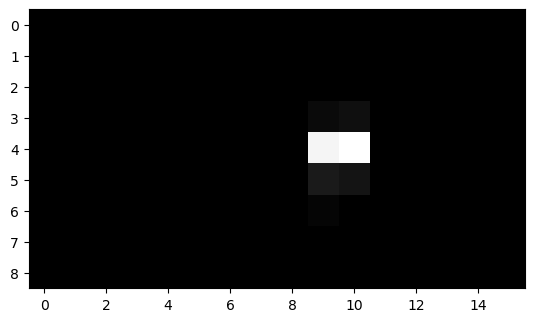

In [12]:
plt.imshow(gt_train_sal_maps['0018'][0].reshape((9, 16)), cmap='gray', interpolation='nearest')

In [13]:
def match_timestamps(head_data, interval, start_time=0, duration=30):
    matched_head_positions = []
    times = np.arange(start_time, start_time + duration, interval)
    for time in times:
        # Find the minimum difference and its index
        closest_diff = np.abs(head_data['t'] - time)
        # print(closest_diff.min())
        # print(closest_diff.max())
        # break
        if closest_diff.min() <= interval / 2:  # Only accept matches within half the interval size
            closest_idx = closest_diff.idxmin()
            row = head_data.iloc[closest_idx]
            matched_head_positions.append([row['u'], row['v']])
        elif closest_diff.min() <= interval:
            # take average of previous and next point and use as current point
            closest_idx = closest_diff.idxmin()
            row = head_data.iloc[closest_idx]

            next_closest_diff = np.abs(head_data['t'] - time + interval)
            next_closest_idx = next_closest_diff.idxmin()
            next_row = head_data.iloc[next_closest_idx]

            u = (row['u'] + next_row['u']) / 2.0
            v = (row['v'] + next_row['v']) / 2.0

            matched_head_positions.append([u, v])
        else:
            # If no close match found, append NaN or another placeholder to indicate missing data
            print(f"No close timestamp found for time {time}s within acceptable range")
            print(f'closest difference was {closest_diff.min()}')
            if len(matched_head_positions) > 20:
                break
            return np.array([])
        
    return np.array(matched_head_positions)

# def get_video_start_time(video):
#     video_table = pd.read_csv('../../datasets/dsav360/video_table.csv')
#     row = video_table.loc[video_table['Name'] == int(video)]
#     return row['Timestamp'].iloc[0]

def load_video_head_data(csv_file, interval):
    # start_time = get_video_start_time(video)
    participants = {}

    df = pd.read_csv(csv_file)
    for p in df['id'].unique():
        df_person = df[df['id'] == p]
        df_person.reset_index(drop=True, inplace=True)
        sequence = match_timestamps(df_person, interval)
        if len(sequence) > 0:
            participants[p] = sequence

    return participants

def load_all_video_head_data(videos, interval=0.25):
    directory = '../../datasets/dsav360/head_data'

    head_data_dict = {}
    
    for video in videos:
        path = os.path.join(directory, f'{video}.csv')
        if os.path.exists(path):
            head_data_dict[video] = load_video_head_data(path, interval)
        else:
            print(f'path to video {video} does not exist: {path}')
    
    return head_data_dict

In [14]:
train_head_data = load_all_video_head_data(gt_train_sal_maps.keys())

No close timestamp found for time 10.5s within acceptable range
closest difference was 0.4095598144531003
No close timestamp found for time 3.5s within acceptable range
closest difference was 0.48717089843749983
No close timestamp found for time 27.75s within acceptable range
closest difference was 0.42426147460939845
No close timestamp found for time 10.25s within acceptable range
closest difference was 0.36110913085937923
No close timestamp found for time 13.0s within acceptable range
closest difference was 0.3868549804686996


In [15]:
def prepare_training_data(saliency_maps, head_positions, sequence_length=15):
    """ Prepare sequences for training. """
    dataX, dataY = [], []
    
    # Ensure the data length matches
    num_samples = min(len(saliency_maps), len(head_positions))
    combined_features = np.hstack([saliency_maps[:num_samples], head_positions[:num_samples]])

    # Create sequences
    for i in range(num_samples - sequence_length):
        end_ix = i + sequence_length
        seqX, seqY = combined_features[i:end_ix], head_positions[end_ix]
        dataX.append(seqX)
        dataY.append(seqY)
    
    return np.array(dataX), np.array(dataY)

def load_and_prepare_all_data(saliency_dict, head_data_dict, sequence_length=15):
    all_dataX, all_dataY = [], []
    
    for video in saliency_dict:
        saliency_maps = saliency_dict[video]
        for participant in head_data_dict[video]:
            head_positions = head_data_dict[video][participant]
            dataX, dataY = prepare_training_data(saliency_maps, head_positions, sequence_length)
            all_dataX.append(dataX)
            all_dataY.append(dataY)

    return np.vstack(all_dataX), np.vstack(all_dataY)

def get_input_output(saliency_dir, videos, interval, sequence_length=15):
    skip_size = int(60 * interval)
    sal_maps = load_saliency_maps_for_all_videos(saliency_dir, skip_size, videos)
    head_data = load_all_video_head_data(videos, interval)
    return load_and_prepare_all_data(sal_maps, head_data, sequence_length)

def get_test_train_input_output(saliency_dir, fold, interval, sequence_length=15):
    train_vids, test_vids = train_folds[fold], test_folds[fold]
    train_x, train_y = get_input_output(saliency_dir, train_vids, interval, sequence_length)
    test_x, test_y = get_input_output(saliency_dir, test_vids, interval, sequence_length)
    return train_x, train_y, test_x, test_y
    

In [16]:
gt_train_x, gt_train_y = load_and_prepare_all_data(gt_train_sal_maps, train_head_data)
print(gt_train_x.shape)
print(gt_train_y.shape)

(77991, 15, 146)
(77991, 2)


In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

def split_dataset_get_loader(x, y):
    # Split the dataset into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=42)  # 20% for validation

    # Convert to PyTorch tensors
    train_X = torch.tensor(x_train, dtype=torch.float32)
    train_Y = torch.tensor(y_train, dtype=torch.float32)
    val_X = torch.tensor(x_val, dtype=torch.float32)
    val_Y = torch.tensor(y_val, dtype=torch.float32)

    # Create DataLoader for training and validation sets
    train_dataset = TensorDataset(train_X, train_Y)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    val_dataset = TensorDataset(val_X, val_Y)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    return train_loader, val_loader

In [18]:
gt_train_loader, gt_val_loader = split_dataset_get_loader(gt_train_x, gt_train_y)

In [19]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=30, patience=3, quiet=False):
    model.to(device)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # Training mode
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, targets) # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            train_loss += loss.item() * inputs.size(0)
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader.dataset)
        
        # Validate the model
        model.eval()  # Evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # No need to track gradients for validation
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        
        if not quiet:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

In [20]:
# Creating the model instance
gt_model = LSTMHeadPosModel()

# Loss function and optimizer
gt_criterion = nn.MSELoss()
gt_optimizer = torch.optim.Adam(gt_model.parameters(), lr=0.001)

# Model summary
print(gt_model)

train_model(gt_model, gt_criterion, gt_optimizer, gt_train_loader, gt_val_loader)

LSTMHeadPosModel(
  (lstm1): LSTM(146, 128, batch_first=True)
  (lstm2): LSTM(128, 128, batch_first=True)
  (dense): Linear(in_features=128, out_features=2, bias=True)
)
Epoch 1/30, Train Loss: 0.0131, Validation Loss: 0.0084
Epoch 2/30, Train Loss: 0.0081, Validation Loss: 0.0091
Epoch 3/30, Train Loss: 0.0077, Validation Loss: 0.0079
Epoch 4/30, Train Loss: 0.0074, Validation Loss: 0.0075
Epoch 5/30, Train Loss: 0.0072, Validation Loss: 0.0073
Epoch 6/30, Train Loss: 0.0070, Validation Loss: 0.0071
Epoch 7/30, Train Loss: 0.0068, Validation Loss: 0.0071
Epoch 8/30, Train Loss: 0.0066, Validation Loss: 0.0067
Epoch 9/30, Train Loss: 0.0063, Validation Loss: 0.0069
Epoch 10/30, Train Loss: 0.0059, Validation Loss: 0.0062
Epoch 11/30, Train Loss: 0.0056, Validation Loss: 0.0059
Epoch 12/30, Train Loss: 0.0053, Validation Loss: 0.0061
Epoch 13/30, Train Loss: 0.0051, Validation Loss: 0.0060
Epoch 14/30, Train Loss: 0.0048, Validation Loss: 0.0055
Epoch 15/30, Train Loss: 0.0047, Validati

In [21]:
torch.save(gt_model.state_dict(), 'trained_models/gt_lstm_model_1.pth')

In [22]:
gt_test_sal_maps = load_saliency_maps_for_all_videos(gt_sal_map_dir, 15, test_folds[0])

In [23]:
test_head_data = load_all_video_head_data(gt_test_sal_maps.keys())

In [24]:
gt_test_x, gt_test_y = load_and_prepare_all_data(gt_test_sal_maps, test_head_data)
print(gt_test_x.shape)
print(gt_test_y.shape)

(24780, 15, 146)
(24780, 2)


In [25]:
gt_test_dataset = TensorDataset(torch.Tensor(gt_test_x), torch.Tensor(gt_test_y))
gt_test_loader = DataLoader(gt_test_dataset, batch_size=64, shuffle=False)

In [26]:
def test_model(model, loader, criterion=nn.MSELoss()):
    model.eval()
    device = next(model.parameters()).device
    test_loss = 0.0

    all_predictions = []
    all_targets = []

    with torch.no_grad(): 
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    test_loss /= len(loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")
    
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    return predictions, targets, test_loss

In [27]:
gt_predictions, gt_targets, gt_test_loss = test_model(gt_model, gt_test_loader)

Test Loss: 0.0048


In [4]:
def uv_to_tile(u, v, width=16, height=9):
    """ Convert continuous (u, v) coordinates to discrete grid tile indices. """
    x = int(np.floor(u * width))
    y = int(np.floor(v * height))

    x = min(x, width - 1)
    y = min(y, height - 1)
    
    return x, y

def calculate_manhattan_tile_dist(predictions, targets, width=16, height=9):
    distances = []

    for pred, true in zip(predictions, targets):
        x1, y1 = uv_to_tile(pred[0], pred[1], width, height)
        x2, y2 = uv_to_tile(true[0], true[1], width, height)

        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        
        # Adjust dx for circular wraparound
        dx = min(dx, width - dx)
        
        dist = dx + dy
        distances.append(dist)

    return np.mean(distances)


def calculate_average_tile_distance(predictions, targets, width=16, height=9):
    distances = []

    for pred, true in zip(predictions, targets):
        x1, y1 = uv_to_tile(pred[0], pred[1])
        x2, y2 = uv_to_tile(true[0], true[1])

        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        
        # Adjust dx for circular wraparound
        dx = min(dx, width - dx)
        
        dist = np.sqrt(dx**2 + dy**2)
        distances.append(dist)

    return np.mean(distances)

def calculate_qoe1(predictions, targets, nrow_tiles, ncol_tiles, pref_bitrate, player_tiles_x, player_tiles_y):
    qoe_scores = []
    
    for pred_pos, act_pos in zip(predictions, targets):
        pred_tile = uv_to_tile(pred_pos[0], pred_pos[1], ncol_tiles, nrow_tiles)
        act_tile = uv_to_tile(act_pos[0], act_pos[1], ncol_tiles, nrow_tiles)
        
        chunk_bitrate = alloc_bitrate([pred_tile], nrow_tiles, ncol_tiles, pref_bitrate, player_tiles_x, player_tiles_y)
        qoe_1 = calc_qoe1(chunk_bitrate, [act_tile], nrow_tiles, ncol_tiles)
        qoe_scores.append(qoe_1)
    
    return np.mean(qoe_scores)

def alloc_bitrate(pred_tiles, nrow_tiles, ncol_tiles, pref_bitrate, player_tiles_x, player_tiles_y):
    chunk_bitrate = [[-1 for x in range(ncol_tiles)] for y in range(nrow_tiles)]
    chunk_weight = [[1. for x in range(ncol_tiles)] for y in range(nrow_tiles)]

    for tile in pred_tiles:
        tile_0 = nrow_tiles - 1 if (tile[0] >= nrow_tiles) else tile[0]
        tile_1 = ncol_tiles - 1 if (tile[1] >= ncol_tiles) else tile[1]
        tile_0 = 0 if (tile_0 < 0) else tile_0
        tile_1 = 0 if (tile_1 < 0) else tile_1
        chunk_weight[tile_0][tile_1] += 1.

        for j in range(nrow_tiles):
            for k in range(ncol_tiles):
                if not (j == tile_0 and k == tile_1):
                    op1 = abs(tile_0 - j) + abs(tile_1 - k)
                    op2, op3 = 0, 0
                    op4 = 0

                    if (j > tile_0):
                        op2 = abs(tile_0 - j + nrow_tiles) + abs(tile_1 - k)
                        op4 += abs(tile_0 - j + nrow_tiles)
                    else:
                        op2 = abs(tile_0 - j - nrow_tiles) + abs(tile_1 - k)
                        op4 += abs(tile_0 - j - nrow_tiles)

                    if (k > tile_1):
                        op3 = abs(tile_0 - j) + abs(tile_1 - k + ncol_tiles)
                        op4 += abs(tile_1 - k + ncol_tiles)
                    else:
                        op3 = abs(tile_0 - j) + abs(tile_1 - k - ncol_tiles)
                        op4 += abs(tile_1 - k - ncol_tiles)

                    dist = min(op1, op2, op3, op4)
                    if (dist <= (player_tiles_x + player_tiles_y) / 2):
                        chunk_weight[j][k] += 1. - (1.0 * dist / 2) / ((ncol_tiles + nrow_tiles) / 2)
                    else:
                        chunk_weight[j][k] += 1. - (1.0 * dist) / ((ncol_tiles + nrow_tiles) / 2)

    total_weight = sum(sum(x) for x in chunk_weight)
    for x in range(nrow_tiles):
        for y in range(ncol_tiles):
            chunk_bitrate[x][y] = chunk_weight[x][y] * pref_bitrate / total_weight

    return chunk_bitrate

def calc_qoe1(chunk_bitrate, act_tiles, nrow_tiles, ncol_tiles):
    qoe_1 = 0
    tile_count = 0
    rows, cols = set(), set()
    
    for tile in act_tiles:
        if tile[0] not in rows or tile[1] not in cols:
            tile_count += 1
            rows.add(tile[0])
            cols.add(tile[1])
            col, row = tile[0], tile[1]
            qoe_1 += chunk_bitrate[row][col]
    
    tile_count = 1 if tile_count == 0 else tile_count
    qoe_1 /= tile_count
    
    return qoe_1

def construct_viewport(center_x, center_y, width=16, height=9, vp_width = 9, vp_height = 5):
    tiles = set()
    for i in range(-vp_width // 2, vp_width // 2 + 1):
        for j in range(-vp_height // 2, vp_height // 2 + 1):
            tile_x = (center_x + i) % width
            tile_y = (center_y + j) % height
            tiles.add((tile_x, tile_y))

    return tiles

def calculate_accuracy(predictions, targets, width = 16, height = 9, vp_width = 9, vp_height = 5):
    accuracy = []

    for pred, true in zip(predictions, targets):
        pred_x, pred_y = uv_to_tile(pred[0], pred[1], width, height)
        gt_x, gt_y = uv_to_tile(true[0], true[1], width, height)

        pred_viewport = construct_viewport(pred_x, pred_y)
        gt_viewport = construct_viewport(gt_x, gt_y)

        count = 0
        for tile in pred_viewport:
            if tile in gt_viewport:
                count += 1
        
        acc = count / len(pred_viewport)
        accuracy.append(acc)
    
    return np.mean(accuracy)

def calculate_angular_dist(predictions, targets):
    distances = []

    for pred, gt in zip(predictions, targets):
        pred_long, pred_lat = pred[0] * 360 - 180, pred[1] * 180 - 90
        gt_long, gt_lat = gt[0] * 360 - 180, gt[1] * 180 - 90 

        dist = angular_distance(pred_lat, pred_long, gt_lat, gt_long)
        distances.append(dist)
    
    return np.mean(distances)


def angular_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    # a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    a = 1 - np.cos(dlat) + np.cos(lat1) * np.cos(lat2) * (1 - np.cos(dlon))
    c = 2 * np.arcsin(np.sqrt(a / 2.0))
    
    # Convert radians to degrees if necessary
    # c = np.degrees(c)
    return c

In [29]:
gt_average_distance = calculate_average_tile_distance(gt_predictions, gt_targets)
print(f"Average Euclidean distance in tile space: {gt_average_distance}")

Average Euclidean distance in tile space: 0.46966339235796


In [30]:
###### BIG ISSUE ALERT BIG ISSUE ALERT

In [31]:
###### BIG ISSUE ALERT BIG ISSUE ALERT

In [32]:
'''
Can't train on the predicted saliency maps of the training videos because CNN was trained on those
so it would be overfit. The LSTM model is trained with the ground truth saliency maps so it may be 
too relient on the CNN and not on the head position vectors. The dataset is currently split so that
there are 16 training videos and 4 testing videos (80/20). I would need to split dataset in the 
following way to overcome the reliance on CNN: 8 CNN training videos, 8 CNN testing videos that are 
also used for LSTM training, and 4 LSTM testing videos (40/40/20). 
'''

"\nCan't train on the predicted saliency maps of the training videos because CNN was trained on those\nso it would be overfit. The LSTM model is trained with the ground truth saliency maps so it may be \ntoo relient on the CNN and not on the head position vectors. The dataset is currently split so that\nthere are 16 training videos and 4 testing videos (80/20). I would need to split dataset in the \nfollowing way to overcome the reliance on CNN: 8 CNN training videos, 8 CNN testing videos that are \nalso used for LSTM training, and 4 LSTM testing videos (40/40/20). \n"

In [33]:
###### BIG ISSUE ALERT BIG ISSUE ALERT

In [34]:
###### BIG ISSUE ALERT BIG ISSUE ALERT

In [35]:
sound_test_sal_map_dir = '../../AVS360/sound/predicted_saliency/dsav'
no_sound_test_sal_map_dir = '../../AVS360/no_sound/predicted_saliency/dsav'

sound_test_sal_maps = load_saliency_maps_for_all_videos(sound_test_sal_map_dir, 15, test_folds[0])
no_sound_test_sal_maps = load_saliency_maps_for_all_videos(no_sound_test_sal_map_dir, 15, test_folds[0])

In [36]:
sound_test_head_data = load_all_video_head_data(sound_test_sal_maps.keys())
no_sound_test_head_data = load_all_video_head_data(no_sound_test_sal_maps.keys())

In [37]:
sound_test_x, sound_test_y = load_and_prepare_all_data(sound_test_sal_maps, sound_test_head_data)
no_sound_test_x, no_sound_test_y = load_and_prepare_all_data(no_sound_test_sal_maps, no_sound_test_head_data)

print(sound_test_x.shape)
print(sound_test_y.shape)
print(no_sound_test_x.shape)
print(no_sound_test_y.shape)

(24780, 15, 146)
(24780, 2)
(24780, 15, 146)
(24780, 2)


In [38]:
sound_test_dataset = TensorDataset(torch.Tensor(sound_test_x), torch.Tensor(sound_test_y))
sound_test_loader = DataLoader(sound_test_dataset, batch_size=64, shuffle=False)

no_sound_test_dataset = TensorDataset(torch.Tensor(no_sound_test_x), torch.Tensor(no_sound_test_y))
no_sound_test_loader = DataLoader(no_sound_test_dataset, batch_size=64, shuffle=False)

In [39]:
sound_predictions, sound_targets, sound_test_loss = test_model(gt_model, sound_test_loader)
no_sound_predictions, no_sound_targets, no_sound_test_loss = test_model(gt_model, no_sound_test_loader)

Test Loss: 0.0061
Test Loss: 0.0058


In [40]:
sound_average_distance = calculate_average_tile_distance(sound_predictions, sound_targets)
no_sound_average_distance = calculate_average_tile_distance(no_sound_predictions, no_sound_targets)

print(f"Average Euclidean distance in tile space WITH SOUND: {sound_average_distance}")
print(f"Average Euclidean distance in tile space WITHOUT SOUND: {no_sound_average_distance}")

Average Euclidean distance in tile space WITH SOUND: 0.5424000936845109
Average Euclidean distance in tile space WITHOUT SOUND: 0.5524724308216805


In [41]:
percent_difference = (abs(sound_average_distance - no_sound_average_distance) / 
                      ((sound_average_distance + no_sound_average_distance) / 2)) * 100

print(f"Percent Difference: {percent_difference:.2f}%")

Percent Difference: 1.84%


In [42]:
# compare indoor focused vs outdoor exploratory
indoor_focused = ['0029', '2006']
outdoor_exploratory = ['1008', '5034']

In [43]:
IF_sound_test_sal_maps = {video:sound_test_sal_maps[video] for video in indoor_focused}
OE_sound_test_sal_maps = {video:sound_test_sal_maps[video] for video in outdoor_exploratory}

IF_no_sound_test_sal_maps = {video:no_sound_test_sal_maps[video] for video in indoor_focused}
OE_no_sound_test_sal_maps = {video:no_sound_test_sal_maps[video] for video in outdoor_exploratory}

KeyError: '2006'

In [ ]:
IF_sound_test_head_data = load_all_video_head_data(IF_sound_test_sal_maps.keys())
OE_sound_test_head_data = load_all_video_head_data(OE_sound_test_sal_maps.keys())

IF_no_sound_test_head_data = load_all_video_head_data(IF_no_sound_test_sal_maps.keys())
OE_no_sound_test_head_data = load_all_video_head_data(OE_no_sound_test_sal_maps.keys())

No close timestamp found for time 13.0s within acceptable range
closest difference was 0.3868549804686996
No close timestamp found for time 13.0s within acceptable range
closest difference was 0.3868549804686996


In [ ]:
IF_sound_test_x, IF_sound_test_y = load_and_prepare_all_data(IF_sound_test_sal_maps, IF_sound_test_head_data)
OE_sound_test_x, OE_sound_test_y = load_and_prepare_all_data(OE_sound_test_sal_maps, OE_sound_test_head_data)


IF_no_sound_test_x, IF_no_sound_test_y = load_and_prepare_all_data(IF_no_sound_test_sal_maps, IF_no_sound_test_head_data)
OE_no_sound_test_x, OE_no_sound_test_y = load_and_prepare_all_data(OE_no_sound_test_sal_maps, OE_no_sound_test_head_data)

print(IF_sound_test_x.shape)
print(IF_sound_test_y.shape)
print(OE_sound_test_x.shape)
print(OE_sound_test_y.shape)

print(IF_no_sound_test_x.shape)
print(IF_no_sound_test_y.shape)
print(OE_no_sound_test_x.shape)
print(OE_no_sound_test_y.shape)

(13545, 15, 146)
(13545, 2)
(10710, 15, 146)
(10710, 2)
(13545, 15, 146)
(13545, 2)
(10710, 15, 146)
(10710, 2)


In [ ]:
IF_sound_test_dataset = TensorDataset(torch.Tensor(IF_sound_test_x), torch.Tensor(IF_sound_test_y))
OE_sound_test_dataset = TensorDataset(torch.Tensor(OE_sound_test_x), torch.Tensor(OE_sound_test_y))

IF_sound_test_loader = DataLoader(IF_sound_test_dataset, batch_size=64, shuffle=False)
OE_sound_test_loader = DataLoader(OE_sound_test_dataset, batch_size=64, shuffle=False)


IF_no_sound_test_dataset = TensorDataset(torch.Tensor(IF_no_sound_test_x), torch.Tensor(IF_no_sound_test_y))
OE_no_sound_test_dataset = TensorDataset(torch.Tensor(OE_no_sound_test_x), torch.Tensor(OE_no_sound_test_y))

IF_no_sound_test_loader = DataLoader(IF_no_sound_test_dataset, batch_size=64, shuffle=False)
OE_no_sound_test_loader = DataLoader(OE_no_sound_test_dataset, batch_size=64, shuffle=False)

In [ ]:
IF_sound_predictions, IF_sound_targets, IF_sound_test_loss = test_model(gt_model, IF_sound_test_loader)
OE_sound_predictions, OE_sound_targets, OE_sound_test_loss = test_model(gt_model, OE_sound_test_loader)
IF_no_sound_predictions, IF_no_sound_targets, IF_no_sound_test_loss = test_model(gt_model, IF_no_sound_test_loader)
OE_no_sound_predictions, OE_no_sound_targets, OE_no_sound_test_loss = test_model(gt_model, OE_no_sound_test_loader)

Test Loss: 0.0049
Test Loss: 0.0081
Test Loss: 0.0055
Test Loss: 0.0097


In [ ]:
IF_sound_average_distance = calculate_average_tile_distance(IF_sound_predictions, IF_sound_targets)
OE_sound_average_distance = calculate_average_tile_distance(OE_sound_predictions, OE_sound_targets)
IF_no_sound_average_distance = calculate_average_tile_distance(IF_no_sound_predictions, IF_no_sound_targets)
OE_no_sound_average_distance = calculate_average_tile_distance(OE_no_sound_predictions, OE_no_sound_targets)

print(f"Average Euclidean distance in tile space WITH SOUND FOR INDOOR FOCUSED: {IF_sound_average_distance}")
print(f"Average Euclidean distance in tile space WITH SOUND FOR OUTDOOR EXPLORATORY: {OE_sound_average_distance}")
print(f"Average Euclidean distance in tile space WITHOUT SOUND FOR INDOOR FOCUSED: {IF_no_sound_average_distance}")
print(f"Average Euclidean distance in tile space WITHOUT SOUND FOR OUTDOOR EXPLORATORY: {OE_no_sound_average_distance}")

Average Euclidean distance in tile space WITH SOUND FOR INDOOR FOCUSED: 0.4567668545224564
Average Euclidean distance in tile space WITH SOUND FOR OUTDOOR EXPLORATORY: 0.6074344980810881
Average Euclidean distance in tile space WITHOUT SOUND FOR INDOOR FOCUSED: 0.5541086803423326
Average Euclidean distance in tile space WITHOUT SOUND FOR OUTDOOR EXPLORATORY: 0.6573068356994821


In [ ]:
IF_percent_difference = (abs(IF_sound_average_distance - IF_no_sound_average_distance) / 
                      ((IF_sound_average_distance + IF_no_sound_average_distance) / 2)) * 100
OE_percent_difference = (abs(OE_sound_average_distance - OE_no_sound_average_distance) / 
                      ((OE_sound_average_distance + OE_no_sound_average_distance) / 2)) * 100

print(f"Percent Difference FOR INDOOR FOCUSED: {IF_percent_difference:.2f}%")
print(f"Percent Difference FOR OUTDOOR EXPLORATORY: {OE_percent_difference:.2f}%")

Percent Difference FOR INDOOR FOCUSED: 19.26%
Percent Difference FOR OUTDOOR EXPLORATORY: 7.89%


In [ ]:
print(360 / 16)
print(180 / 9)

22.5
20.0


In [83]:
i = 0
gt_train_x, gt_train_y = get_input_output(gt_sal_map_dir, train_folds[i], interval=0.5, sequence_length=15)

gt_train_loader, gt_val_loader = split_dataset_get_loader(gt_train_x, gt_train_y)
gt_model= LSTMHeadPosModel()
gt_optimizer= torch.optim.Adam(gt_model.parameters(), lr=0.001)

train_model(gt_model, gt_criterion, gt_optimizer, gt_train_loader, gt_val_loader)

torch.save(gt_model.state_dict(), f'trained_models/gt/test_parima.pth')

No close timestamp found for time 28.0s within acceptable range
closest difference was 0.6742614746093984
No close timestamp found for time 10.5s within acceptable range
closest difference was 0.6111091308593792
No close timestamp found for time 4.0s within acceptable range
closest difference was 0.9871708984374998
Epoch 1/30, Train Loss: 0.0235, Validation Loss: 0.0164
Epoch 2/30, Train Loss: 0.0144, Validation Loss: 0.0149
Epoch 3/30, Train Loss: 0.0139, Validation Loss: 0.0143
Epoch 4/30, Train Loss: 0.0134, Validation Loss: 0.0141
Epoch 5/30, Train Loss: 0.0130, Validation Loss: 0.0134
Epoch 6/30, Train Loss: 0.0127, Validation Loss: 0.0131
Epoch 7/30, Train Loss: 0.0124, Validation Loss: 0.0131
Epoch 8/30, Train Loss: 0.0122, Validation Loss: 0.0126
Epoch 9/30, Train Loss: 0.0119, Validation Loss: 0.0123
Epoch 10/30, Train Loss: 0.0117, Validation Loss: 0.0123
Epoch 11/30, Train Loss: 0.0115, Validation Loss: 0.0121
Epoch 12/30, Train Loss: 0.0113, Validation Loss: 0.0120
Epoch 13

In [89]:
import sys

parima_prediction_path = os.path.abspath('../../PARIMA/Prediction')

# Add this path to sys.path to make it searchable
sys.path.append(parima_prediction_path)

# Now you can import the qoe function
from qoe import calc_qoe
from bitrate import alloc_bitrate

width = 2880
height = 1600
ncol_tiles = 8
nrow_tiles = 8
player_width = width
player_height = height
player_tiles_x = math.ceil(player_width * ncol_tiles * 1.0 / width)
player_tiles_y = math.ceil(player_height * nrow_tiles * 1.0 / height)

def generate_chunk_frames(total_frames, fps, chunk_duration):
    frames_in_chunk = fps * chunk_duration
    chunk_frames = []
    i = 0
    while i < total_frames:
        chunk = list(range(i, i + frames_in_chunk))
        chunk_frames.append(chunk)
        i += frames_in_chunk
            
    return chunk_frames

# Using the function
total_frames = 1800  # e.g., 30 seconds of video at 30 fps
fps = 60
chunk_duration = 0.5
chunk_frames = generate_chunk_frames(total_frames, fps, chunk_duration)

In [107]:
for video in test_folds[0]:
    gt_test_x, gt_test_y = get_input_output(gt_sal_map_dir, [video], interval=0.5, sequence_length=15)
    gt_test_dataset = TensorDataset(torch.Tensor(gt_test_x), torch.Tensor(gt_test_y))
    gt_test_loader = DataLoader(gt_test_dataset, batch_size=64, shuffle=False)

    gt_predictions, gt_targets, gt_test_loss = test_model(gt_model, gt_test_loader)

    # predicted_tiles = [uv_to_tile(pred[0], pred[1], width=16, height=9) for pred in gt_predictions]
    # actual_tiles = [uv_to_tile(gt[0], gt[1], width=16, height=9) for gt in gt_targets]

    manhattan_dist = calculate_manhattan_tile_dist(gt_predictions, gt_targets)
    avg_btr = calculate_qoe1(gt_predictions, gt_targets, nrow_tiles=9, ncol_tiles=16, pref_bitrate=16, player_tiles_x=9, player_tiles_y=5)
    test_btr = calculate_qoe1(gt_targets, gt_targets, nrow_tiles=9, ncol_tiles=16, pref_bitrate=16, player_tiles_x=9, player_tiles_y=5)


    # gt_average_distance = calculate_average_tile_distance(gt_predictions, gt_targets)

    # # Allocate bitrates
    # pref_bitrate = 8 #'1080p'  1080p mapped to 8 in paper
    # vid_bitrate = alloc_bitrate(predicted_tiles, chunk_frames, nrow_tiles, ncol_tiles, pref_bitrate, player_tiles_x, player_tiles_y)

    # Calculate QoE
    # qoe = calc_qoe(vid_bitrate, actual_tiles, chunk_frames, width, height, nrow_tiles, ncol_tiles, player_width, player_height)
    
    print(f'Topic: {video}')
    print(f'User ID: all')
    print(f'BTR: {avg_btr}')
    print(f'BEST: {test_btr}')
    print(f'MTE: {manhattan_dist}')

Test Loss: 0.0080
Topic: 1006
User ID: all
BTR: 0.11344708335071566
BEST: 0.1119580855681671
MTE: 1.077621283255086
Test Loss: 0.0023
Topic: 0029
User ID: all
BTR: 0.11853967800550673
BEST: 0.11735807179640642
MTE: 0.6461028192371476
Test Loss: 0.0149
Topic: 2013
User ID: all
BTR: 0.10385589642555584
BEST: 0.10278280371159626
MTE: 1.1290849673202614
Test Loss: 0.0242
Topic: 5031
User ID: all
BTR: 0.10765904660641501
BEST: 0.1060975671501987
MTE: 1.6503703703703703


In [46]:
sound_sal_map_dir = '../../AVS360/sound/predicted_saliency/dsav'
no_sound_sal_map_dir = '../../AVS360/no_sound/predicted_saliency/dsav'
gt_sal_map_dir = '../../datasets/dsav360/saliency_maps'


def get_percent_difference(x, y):
    return ((x - y) / ((x + y) / 2)) * 100

In [176]:
with open('all_model_results.csv', mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Sequence Length', 'video', 'indoor-focused','GT Distance', 'Sound Distance', 'No Sound Distance', 'GT Acc', 'Sound Acc', 'No Sound Acc'])

In [177]:
# sequence_lengths = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
# intervals = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]

sequence_lengths = [15]
intervals = [1.0]

preds_and_targs = {}
for seq_len in sequence_lengths:
    preds_and_targs[seq_len] = {}
    for video in train_folds[0] + test_folds[0]:
        preds_and_targs[seq_len][video] = {'gt': None, 'sound': None, 'no_sound': None}

for sequence_length in sequence_lengths:
    gt_dist, sound_dist, no_sound_dist = [], [], []
    for i in range(N_FOLDS):
        gt_train_x, gt_train_y = get_input_output(gt_sal_map_dir, train_folds[i], interval=intervals[0], sequence_length=sequence_length)
        sound_train_x, sound_train_y = get_input_output(sound_sal_map_dir, train_folds[i], interval=intervals[0], sequence_length=sequence_length)
        no_sound_train_x, no_sound_train_y = get_input_output(no_sound_sal_map_dir, train_folds[i], interval=intervals[0], sequence_length=sequence_length)

        gt_train_loader, gt_val_loader = split_dataset_get_loader(gt_train_x, gt_train_y)
        sound_train_loader, sound_val_loader = split_dataset_get_loader(sound_train_x, sound_train_y)
        no_sound_train_loader, no_sound_val_loader = split_dataset_get_loader(no_sound_train_x, no_sound_train_y)

        gt_criterion, sound_criterion, no_sound_criterion = nn.MSELoss(), nn.MSELoss(), nn.MSELoss()
        gt_model, sound_model, no_sound_model = LSTMHeadPosModel(), LSTMHeadPosModel(), LSTMHeadPosModel()
        gt_optimizer, sound_optimizer, no_sound_optimizer = torch.optim.Adam(gt_model.parameters(), lr=0.001), torch.optim.Adam(sound_model.parameters(), lr=0.001), torch.optim.Adam(no_sound_model.parameters(), lr=0.001)

        train_model(gt_model, gt_criterion, gt_optimizer, gt_train_loader, gt_val_loader)
        train_model(sound_model, sound_criterion, sound_optimizer, sound_train_loader, sound_val_loader)
        train_model(no_sound_model, no_sound_criterion, no_sound_optimizer, no_sound_train_loader, no_sound_val_loader)

        torch.save(gt_model.state_dict(), f'trained_models/gt/lstm_model_fold_{i+1}_pred_len_1_seq_len_{sequence_length}.pth')
        torch.save(sound_model.state_dict(), f'trained_models/sound/_lstm_model_fold_{i+1}_pred_len_1_seq_len_{sequence_length}.pth')
        torch.save(no_sound_model.state_dict(), f'trained_models/no_sound/_lstm_model_fold_{i+1}_pred_len_1_seq_len_{sequence_length}.pth')
        
        for video in test_folds[i]:
            gt_test_x, gt_test_y = get_input_output(gt_sal_map_dir, [video], interval=intervals[0], sequence_length=sequence_length)
            sound_test_x, sound_test_y = get_input_output(sound_sal_map_dir, [video], interval=intervals[0], sequence_length=sequence_length)
            no_sound_test_x, no_sound_test_y = get_input_output(no_sound_sal_map_dir, [video], interval=intervals[0], sequence_length=sequence_length)

            gt_test_dataset = TensorDataset(torch.Tensor(gt_test_x), torch.Tensor(gt_test_y))
            gt_test_loader = DataLoader(gt_test_dataset, batch_size=64, shuffle=False)

            sound_test_dataset = TensorDataset(torch.Tensor(sound_test_x), torch.Tensor(sound_test_y))
            sound_test_loader = DataLoader(sound_test_dataset, batch_size=64, shuffle=False)

            no_sound_test_dataset = TensorDataset(torch.Tensor(no_sound_test_x), torch.Tensor(no_sound_test_y))
            no_sound_test_loader = DataLoader(no_sound_test_dataset, batch_size=64, shuffle=False)

            gt_predictions, gt_targets, gt_test_loss = test_model(gt_model, gt_test_loader)
            # sound_predictions, sound_targets, sound_test_loss = test_model(gt_model, sound_test_loader)
            # no_sound_predictions, no_sound_targets, no_sound_test_loss = test_model(gt_model, no_sound_test_loader)
            sound_predictions, sound_targets, sound_test_loss = test_model(sound_model, sound_test_loader)
            no_sound_predictions, no_sound_targets, no_sound_test_loss = test_model(no_sound_model, no_sound_test_loader)

            preds_and_targs[sequence_length][video]['gt'] = (gt_predictions, gt_targets)
            preds_and_targs[sequence_length][video]['sound'] = (sound_predictions, sound_targets)
            preds_and_targs[sequence_length][video]['no_sound'] = (no_sound_predictions, no_sound_targets)


            gt_dist = calculate_angular_dist(gt_predictions, gt_targets)
            sound_dist = calculate_angular_dist(sound_predictions, sound_targets)
            no_sound_dist = calculate_angular_dist(no_sound_predictions, no_sound_targets)

            gt_acc = calculate_accuracy(gt_predictions, gt_targets)
            sound_acc = calculate_accuracy(sound_predictions, sound_targets)
            no_sound_acc = calculate_accuracy(no_sound_predictions, no_sound_targets)


            formatted_gt_dist = f'{gt_dist:.5f}'
            formatted_sound_dist = f'{sound_dist:.5f}'
            formatted_no_sound_dist = f'{no_sound_dist:.5f}'

            formatted_gt_acc = f'{gt_acc:.5f}'
            formatted_sound_acc = f'{sound_acc:.5f}'
            formatted_no_sound_acc = f'{no_sound_acc:.5f}'

            indoor_focused = video in indoor_focused_videos
            # Write formatted results to the CSV file
            with open('all_model_results.csv', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(
                    [sequence_length, video, indoor_focused,formatted_gt_dist, formatted_sound_dist, formatted_no_sound_dist, formatted_gt_acc, formatted_sound_acc, formatted_no_sound_acc]
                )


    #     print(f"FOLD #{i + 1}:")
    #     print(f"Test Loss (GT): {gt_test_loss}")
    #     print(f"Test Loss (SOUND): {sound_test_loss}")
    #     print(f"Test Loss (NO SOUND): {no_sound_test_loss}")

    #     print(f"Average Euclidean distance in tile space (GT): {gt_average_distance}")
    #     print(f"Average Euclidean distance in tile space (SOUND): {sound_average_distance}")
    #     print(f"Average Euclidean distance in tile space (NO SOUND): {no_sound_average_distance}")

    #     percent_difference = get_percent_difference(sound_average_distance, no_sound_average_distance)

    #     print(f"Percent Difference (sound vs. no sound): {percent_difference:.2f}%")

    #     fold_losses.append((gt_test_loss, sound_test_loss, no_sound_test_loss))
    #     fold_distances.append((gt_average_distance, sound_average_distance, no_sound_average_distance))

    # losses.append(fold_losses)
    # distances.append(fold_distances)


No close timestamp found for time 11.0s within acceptable range
closest difference was 1.1111091308593792
No close timestamp found for time 11.0s within acceptable range
closest difference was 1.1111091308593792
No close timestamp found for time 11.0s within acceptable range
closest difference was 1.1111091308593792
Epoch 1/30, Train Loss: 0.0385, Validation Loss: 0.0244
Epoch 2/30, Train Loss: 0.0237, Validation Loss: 0.0229
Epoch 3/30, Train Loss: 0.0234, Validation Loss: 0.0239
Epoch 4/30, Train Loss: 0.0229, Validation Loss: 0.0234
Epoch 5/30, Train Loss: 0.0226, Validation Loss: 0.0231
Early stopping triggered at epoch 5
Epoch 1/30, Train Loss: 0.0389, Validation Loss: 0.0258
Epoch 2/30, Train Loss: 0.0243, Validation Loss: 0.0240
Epoch 3/30, Train Loss: 0.0233, Validation Loss: 0.0247
Epoch 4/30, Train Loss: 0.0232, Validation Loss: 0.0236
Epoch 5/30, Train Loss: 0.0231, Validation Loss: 0.0235
Epoch 6/30, Train Loss: 0.0228, Validation Loss: 0.0229
Epoch 7/30, Train Loss: 0.0227

In [178]:
df = pd.read_csv('all_model_results.csv')
grouped = df.groupby(['Sequence Length', 'indoor-focused']).mean()
grouped['Distance Difference'] = grouped['Sound Distance'] - grouped['No Sound Distance']
grouped['Acc Difference'] = grouped['Sound Acc'] - grouped['No Sound Acc']

sorted_df = grouped.sort_values(by='Distance Difference', ascending=False)
sorted_df.to_csv('sorted_aggregated_distances.csv')

In [181]:
with open('best_model_results.csv', mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['model', 'prediction','actual'])

best_seq_len = preds_and_targs[13]

for _, val in best_seq_len.items():
    for model, pred_targ_arrs in val.items():
        preds, targs = pred_targ_arrs
        with open('best_model_results_13.csv', mode='a', newline='') as file:
            writer = csv.writer(file)
            for pred, targ in zip(preds, targs):
                writer.writerow(
                    [model, pred, targ]
                )

<Figure size 1000x500 with 0 Axes>

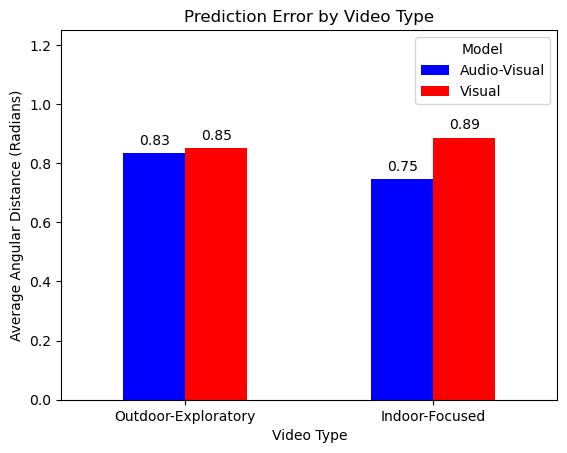

In [12]:
import matplotlib.pyplot as plt
# First Bar Chart: Overall averages
df = pd.read_csv('sorted_aggregated_distances.csv')
df = df[df['Sequence Length'] == 15]

# plt.figure(figsize=(10, 5))
# df.plot(kind='bar', color=['blue', 'red'])
# plt.title('Prediction Error Across Videos')
# plt.ylabel('Average Manhattan Tile Distance')
# plt.xticks(ticks=range(2), labels=['Sound', 'No Sound'], rotation=0)
# plt.ylim(0, 3.25)
# plt.show()

# Second Bar Chart: Comparing Indoor Focused True vs False
plt.figure(figsize=(10, 5))
ax = df.set_index('indoor-focused')[['Sound Distance', 'No Sound Distance']].plot(kind='bar', color=['blue', 'red'])

# Adding labels to each bar
for p in ax.patches:  # loop through each bar in the plot
    ax.annotate(f'{p.get_height():.2f}',  # text to display (rounded to 2 decimal places)
                (p.get_x() + p.get_width() / 2., p.get_height()),  # position (center of the bar, top of the bar)
                ha='center',  # center horizontally
                va='center',  # center vertically
                xytext=(0, 9),  # position text slightly above the top of the bar
                textcoords='offset points')
    
    
plt.title('Prediction Error by Video Type')
plt.xlabel('Video Type')
plt.ylabel('Average Angular Distance (Radians)')
plt.xticks(ticks=range(2), labels=['Outdoor-Exploratory', 'Indoor-Focused'], rotation=0)
plt.ylim(0, 1.25)
plt.legend(['Audio-Visual', 'Visual'], title='Model')
plt.show()

<Figure size 1000x500 with 0 Axes>

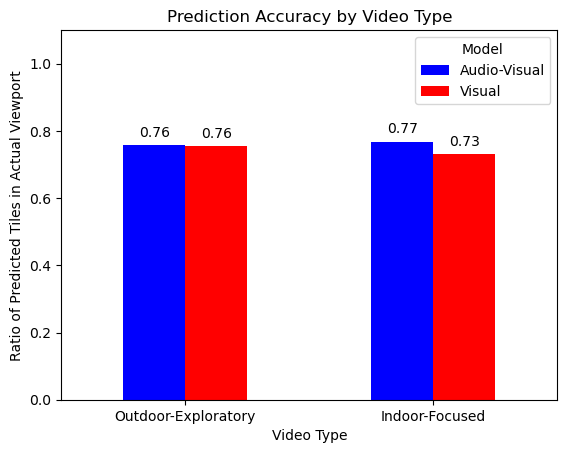

In [13]:
# Second Bar Chart: Comparing Indoor Focused True vs False
plt.figure(figsize=(10, 5))
ax = df.set_index('indoor-focused')[['Sound Acc', 'No Sound Acc']].plot(kind='bar', color=['blue', 'red'])

# Adding labels to each bar
for p in ax.patches:  # loop through each bar in the plot
    ax.annotate(f'{p.get_height():.2f}',  # text to display (rounded to 2 decimal places)
                (p.get_x() + p.get_width() / 2., p.get_height()),  # position (center of the bar, top of the bar)
                ha='center',  # center horizontally
                va='center',  # center vertically
                xytext=(0, 9),  # position text slightly above the top of the bar
                textcoords='offset points')


plt.title('Prediction Accuracy by Video Type')
plt.xlabel('Video Type')
plt.ylabel('Ratio of Predicted Tiles in Actual Viewport')
plt.xticks(ticks=range(2), labels=['Outdoor-Exploratory', 'Indoor-Focused'], rotation=0)
plt.ylim(0, 1.1)
plt.legend(['Audio-Visual', 'Visual'], title='Model')
plt.show()

In [5]:
data = {
    'gt': {'predictions': [], 'targets': []},
    'sound': {'predictions': [], 'targets': []},
    'no_sound': {'predictions': [], 'targets': []}
}

first = True
with open('best_model_results.csv', 'r') as file:
    csv_reader = csv.reader(file)
    
    # Iterate over each row in the CSV file
    for row in csv_reader:
        if first:
            first = False
            continue
        # Extract the model type, prediction, and actual values from the row
        model_type = row[0]
        prediction = row[1].strip('[]').split()
        actual = row[2].strip('[]').split()
        
        # Convert the prediction and actual values to floats
        prediction = [float(prediction[0]), float(prediction[1])]
        actual = [float(actual[0]), float(actual[1])]
        
        # Append the prediction and actual values to the corresponding lists based on the model type
        data[model_type]['predictions'].append(prediction)
        data[model_type]['targets'].append(actual)

# Print the resulting lists for each model type
for model_type in data:
    print(f"Model Type: {model_type}")
    print("Predictions:")
    print(data[model_type]['predictions'])
    print("Actuals:")
    print(data[model_type]['targets'])
    print()

Model Type: gt
Predictions:
[[0.430884, 0.54092884], [0.33516976, 0.55768496], [0.2696991, 0.5513342], [0.22933957, 0.5514808], [0.22499183, 0.5772227], [0.22037008, 0.57889104], [0.1952878, 0.57540596], [0.18770924, 0.5593359], [0.6678002, 0.53801835], [0.13983525, 0.5452409], [0.18820584, 0.54251575], [0.1770295, 0.548467], [0.18175122, 0.5542113], [0.18342729, 0.5490699], [0.18837631, 0.5510878], [0.23349267, 0.5464572], [0.20071901, 0.56551886], [0.27308348, 0.54575557], [0.39950797, 0.5331129], [0.45389003, 0.5079243], [0.4184372, 0.5037501], [0.32748374, 0.5364202], [0.26240644, 0.52812237], [0.2448, 0.5344029], [0.26991796, 0.52915704], [0.25718114, 0.5216269], [0.24665913, 0.5242425], [0.24525332, 0.52465516], [0.23652259, 0.5218174], [0.2443862, 0.5204212], [0.23515394, 0.52066636], [0.2247388, 0.525619], [0.23711833, 0.5272105], [0.21470502, 0.53969306], [0.40027353, 0.55185443], [0.46704286, 0.49530298], [0.1997097, 0.5218499], [0.5794672, 0.5525819], [0.5995863, 0.59885347]

In [17]:
def calculate_angular_distances(predictions, targets):
    distances = []

    for pred, gt in zip(predictions, targets):
        pred_long, pred_lat = pred[0] * 360 - 180, pred[1] * 180 - 90
        gt_long, gt_lat = gt[0] * 360 - 180, gt[1] * 180 - 90 

        dist = angular_distance(pred_lat, pred_long, gt_lat, gt_long)
        distances.append(dist)
    
    return distances

gt_dist = calculate_angular_distances(data['gt']['predictions'], data['gt']['targets'])
sound_dist = calculate_angular_distances(data['sound']['predictions'], data['sound']['targets'])
no_sound_dist = calculate_angular_distances(data['no_sound']['predictions'], data['no_sound']['targets'])

print(gt_dist)
print(sound_dist)
print(no_sound_dist)

[0.429364341823696, 0.6244184477702264, 0.376619581687434, 0.3772013410817173, 0.5792037246133255, 0.8360337290760033, 1.0752849397320072, 1.60942083585934, 2.250871531463082, 0.6556536778547795, 0.6693516473521975, 0.7075735209566977, 0.5605221788858719, 0.3159390911943289, 0.17357451435963858, 0.4062479181180553, 0.3973999955408089, 1.0565745114668896, 0.8230295345945531, 0.6504561523211926, 0.25286374885869184, 0.5390804069114329, 0.17595572850832042, 0.06924490142889432, 0.2791809915956239, 0.19909189510907715, 0.09712603183483694, 0.10136277722075687, 0.04815351652791463, 0.08743167380847812, 0.04624661865573628, 0.023802892944752435, 0.15667677534164215, 0.05851485896793986, 1.0912765846453119, 2.308848559623395, 2.340655479481129, 1.6627606082883644, 1.6231481670837986, 1.7406675592460388, 2.531599788959022, 0.21622491950709927, 0.0994903235281251, 0.14280007996983324, 0.09327262973999631, 0.33880588890527913, 0.32151505458379037, 0.09482078769428925, 0.05784131990962509, 0.4049

In [12]:
# Calculate mean and standard deviation for ground truth distances
gt_mean = np.mean(gt_dist)
gt_std = np.std(gt_dist)

# Calculate mean and standard deviation for sound distances
sound_mean = np.mean(sound_dist)
sound_std = np.std(sound_dist)

# Calculate mean and standard deviation for no sound distances
no_sound_mean = np.mean(no_sound_dist)
no_sound_std = np.std(no_sound_dist)

# Print results
print(f"Ground Truth - Mean: {gt_mean:.2f}, Standard Deviation: {gt_std:.2f}")
print(f"With Sound - Mean: {sound_mean:.2f}, Standard Deviation: {sound_std:.2f}")
print(f"No Sound - Mean: {no_sound_mean:.2f}, Standard Deviation: {no_sound_std:.2f}")


Ground Truth - Mean: 0.77, Standard Deviation: 0.62
With Sound - Mean: 0.79, Standard Deviation: 0.62
No Sound - Mean: 0.85, Standard Deviation: 0.65


In [14]:
# Calculate quartiles for ground truth distances
gt_q1 = np.percentile(gt_dist, 25)  # 25th percentile
gt_median = np.percentile(gt_dist, 50)  # 50th percentile, also the median
gt_q3 = np.percentile(gt_dist, 75)  # 75th percentile

# Calculate quartiles for distances with sound
sound_q1 = np.percentile(sound_dist, 25)
sound_median = np.percentile(sound_dist, 50)
sound_q3 = np.percentile(sound_dist, 75)

# Calculate quartiles for distances without sound
no_sound_q1 = np.percentile(no_sound_dist, 25)
no_sound_median = np.percentile(no_sound_dist, 50)
no_sound_q3 = np.percentile(no_sound_dist, 75)

# Print results
print("Ground Truth - Q1: {:.2f}, Median: {:.2f}, Q3: {:.2f}".format(gt_q1, gt_median, gt_q3))
print("With Sound - Q1: {:.2f}, Median: {:.2f}, Q3: {:.2f}".format(sound_q1, sound_median, sound_q3))
print("No Sound - Q1: {:.2f}, Median: {:.2f}, Q3: {:.2f}".format(no_sound_q1, no_sound_median, no_sound_q3))


Ground Truth - Q1: 0.29, Median: 0.58, Q3: 1.11
With Sound - Q1: 0.28, Median: 0.62, Q3: 1.18
No Sound - Q1: 0.32, Median: 0.69, Q3: 1.19


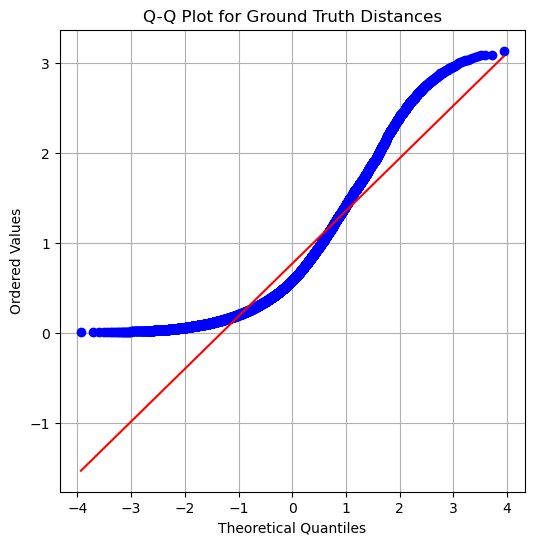

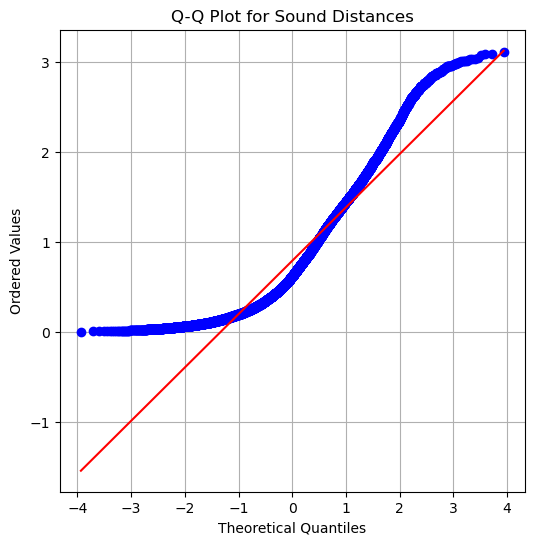

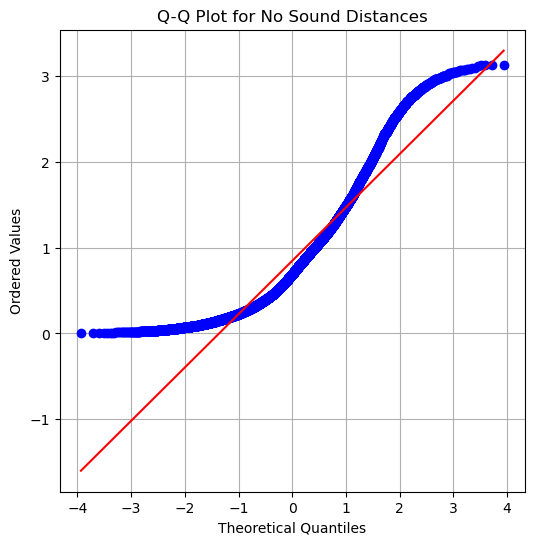

In [15]:
import scipy.stats as stats

# Function to plot Q-Q plot
def qq_plot(data, title):
    fig = plt.figure(figsize=(6, 6))
    res = stats.probplot(data, dist="norm", plot=plt)
    plt.title(title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Values')
    plt.grid(True)

# Generate Q-Q plots
qq_plot(gt_dist, 'Q-Q Plot for Ground Truth Distances')
qq_plot(sound_dist, 'Q-Q Plot for Sound Distances')
qq_plot(no_sound_dist, 'Q-Q Plot for No Sound Distances')

# Show plots
plt.show()


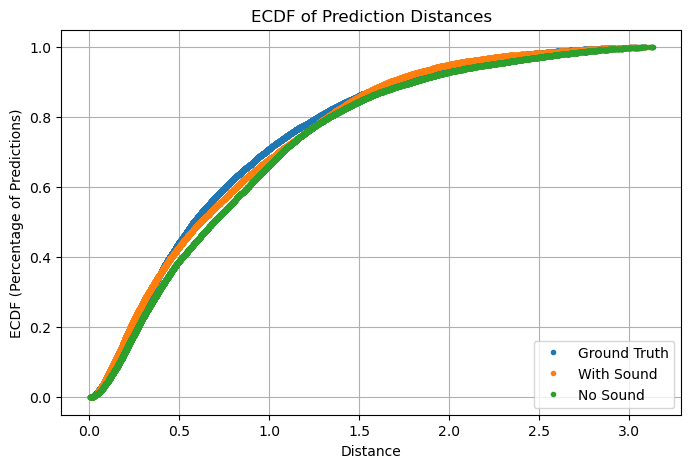

In [18]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

# Compute ECDFs
x_gt, y_gt = ecdf(gt_dist)
x_sound, y_sound = ecdf(sound_dist)
x_no_sound, y_no_sound = ecdf(no_sound_dist)

# Plotting the ECDFs
plt.figure(figsize=(8, 5))
plt.plot(x_gt, y_gt, marker='.', linestyle='none', label='Ground Truth')
plt.plot(x_sound, y_sound, marker='.', linestyle='none', label='With Sound')
plt.plot(x_no_sound, y_no_sound, marker='.', linestyle='none', label='No Sound')
plt.legend(loc='lower right')
plt.title('ECDF of Prediction Distances')
plt.xlabel('Distance')
plt.ylabel('ECDF (Percentage of Predictions)')
plt.grid(True)
plt.show()


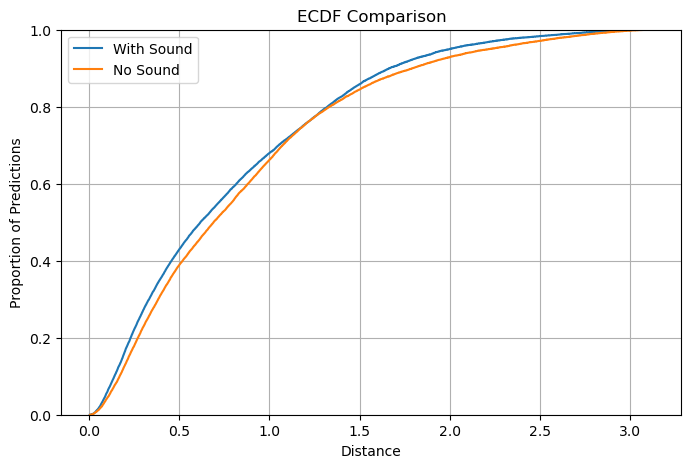

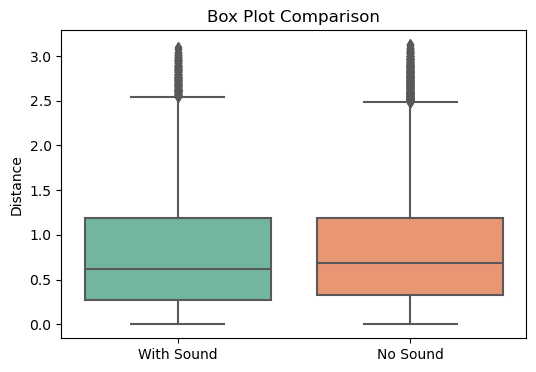

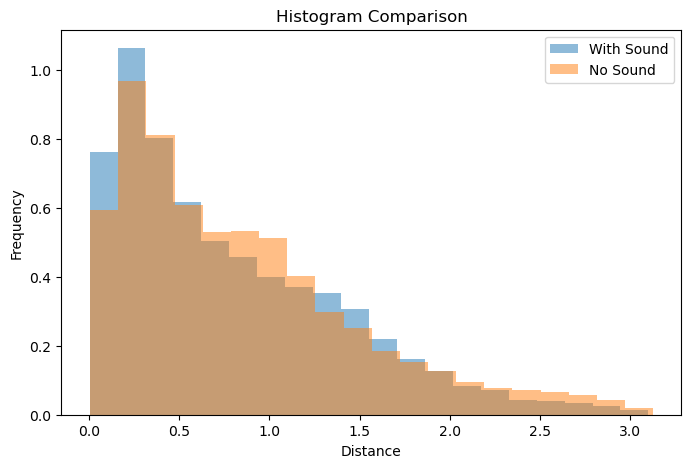

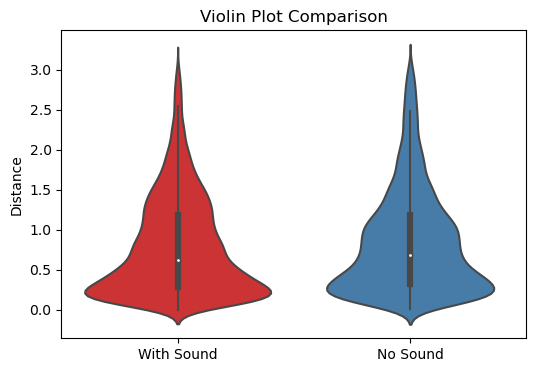

In [21]:
import seaborn as sns



# ECDF Plot
plt.figure(figsize=(8, 5))
sns.ecdfplot(sound_dist, label='With Sound')
sns.ecdfplot(no_sound_dist, label='No Sound')
plt.title('ECDF Comparison')
plt.xlabel('Distance')
plt.ylabel('Proportion of Predictions')
plt.legend()
plt.grid(True)
plt.show()

# Box Plot
plt.figure(figsize=(6, 4))
sns.boxplot(data=[sound_dist, no_sound_dist], orient='v', palette="Set2")
plt.xticks([0, 1], ['With Sound', 'No Sound'])
plt.title('Box Plot Comparison')
plt.ylabel('Distance')
plt.show()

# Histogram
plt.figure(figsize=(8, 5))
plt.hist(sound_dist, bins=20, alpha=0.5, label='With Sound', density=True)
plt.hist(no_sound_dist, bins=20, alpha=0.5, label='No Sound', density=True)
plt.title('Histogram Comparison')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Violin Plot
plt.figure(figsize=(6, 4))
sns.violinplot(data=[sound_dist, no_sound_dist], orient='v', palette="Set1")
plt.xticks([0, 1], ['With Sound', 'No Sound'])
plt.title('Violin Plot Comparison')
plt.ylabel('Distance')
plt.show()


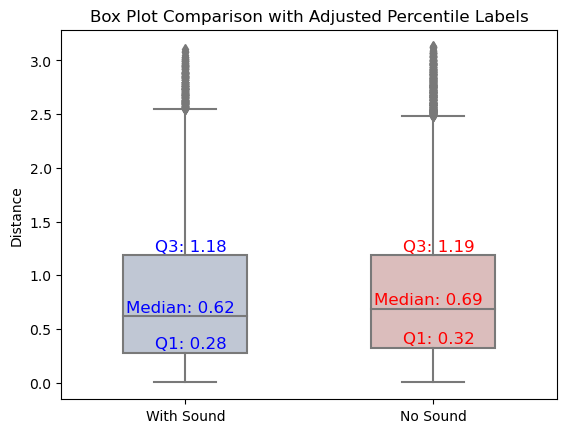

In [42]:
fig, ax = plt.subplots()

# Boxplot
data = [sound_dist, no_sound_dist]
sns.boxplot(data=data, ax=ax, width=0.5, palette="vlag")

# Calculate percentiles for labels
sound_q1, sound_median, sound_q3 = np.percentile(sound_dist, [25, 50, 75])
no_sound_q1, no_sound_median, no_sound_q3 = np.percentile(no_sound_dist, [25, 50, 75])

# Offset for label positioning
offset = 0.08  # Adjust this value based on your specific plot scale

# Adding percentile labels with adjusted vertical position
# For 'With Sound'
ax.text(0.165, sound_q1 + offset, f'Q1: {sound_q1:.2f}', verticalalignment='center', horizontalalignment='right', color='blue', fontsize=12)
ax.text(0.2, sound_median + offset, f'Median: {sound_median:.2f}', verticalalignment='center', horizontalalignment='right', color='blue', fontsize=12)
ax.text(0.165, sound_q3 + offset, f'Q3: {sound_q3:.2f}', verticalalignment='center', horizontalalignment='right', color='blue', fontsize=12)

# For 'No Sound'
ax.text(1.165, no_sound_q1 + offset, f'Q1: {no_sound_q1:.2f}', verticalalignment='center', horizontalalignment='right', color='red', fontsize=12)
ax.text(1.2, no_sound_median + offset, f'Median: {no_sound_median:.2f}', verticalalignment='center', horizontalalignment='right', color='red', fontsize=12)
ax.text(1.165, no_sound_q3 + offset, f'Q3: {no_sound_q3:.2f}', verticalalignment='center', horizontalalignment='right', color='red', fontsize=12)

# Set plot titles and labels
ax.set_title('Box Plot Comparison with Adjusted Percentile Labels')
ax.set_xticklabels(['With Sound', 'No Sound'])
ax.set_ylabel('Distance')
plt.show()

In [48]:
data = {
    'Video Type': ['Outdoor-Exploratory', 'Indoor-Focused'],
    'Audio-Visual Acc': [0.76, 0.77],
    'Visual Acc': [0.76, 0.73],
    'Audio-Visual Std': [0.05, 0.04],  # Example standard deviations
    'Visual Std': [0.03, 0.05]
}

df = pd.DataFrame(data).set_index('Video Type')

# Plotting the bars
ax = df[['Audio-Visual Acc', 'Visual Acc']].plot(kind='bar', color=['blue', 'red'], figsize=(10, 5), yerr=df[['Audio-Visual Std', 'Visual Std']].values.T, error_kw=dict(capsize=5))

# Adding labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title('Prediction Accuracy by Video Type')
plt.xlabel('Video Type')
plt.ylabel('Ratio of Predicted Tiles in Actual Viewport')
plt.xticks(ticks=range(2), labels=['Outdoor-Exploratory', 'Indoor-Focused'], rotation=0)
plt.ylim(0, 1.1)
plt.legend(['Audio-Visual', 'Visual'], title='Model')
plt.show()

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

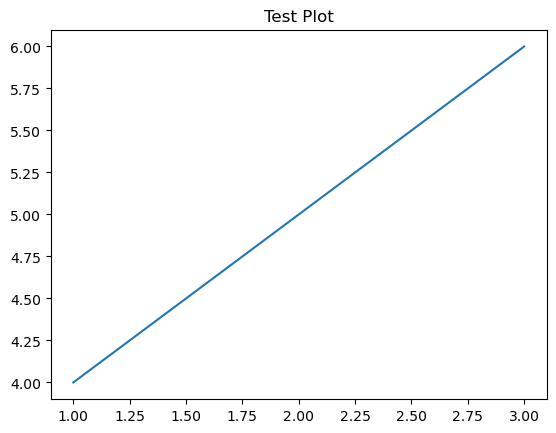

In [45]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([1, 2, 3], [4, 5, 6])
plt.title("Test Plot")
plt.show()

In [27]:

from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr, wasserstein_distance, entropy
import scipy.stats as stats

def compute_statistical_significance(a, b):
    # Check normality
    if stats.shapiro(a) > 0.05 and stats.shapiro(v) > 0.05:
        # If both groups are normally distributed
        stat, p = stats.ttest_rel(a, v)
        print('normally distributed')
    else:
        stat, p = stats.wilcoxon(a, v)

    print(p)

In [ ]:
compute_statistical_significance()